# Train Base Model Augmentation

## Load the data

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import shutil


# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [ ]:
from tensorflow import data as tf_data

# Define dataset paths
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42 # seed for reproducibility
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred', # Infer labels from directory names
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False, # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")


# Prefetch datasets
AUTOTUNE = tf_data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetched.")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded and prefetched.


Data augmentation applied and datasets prefetched.


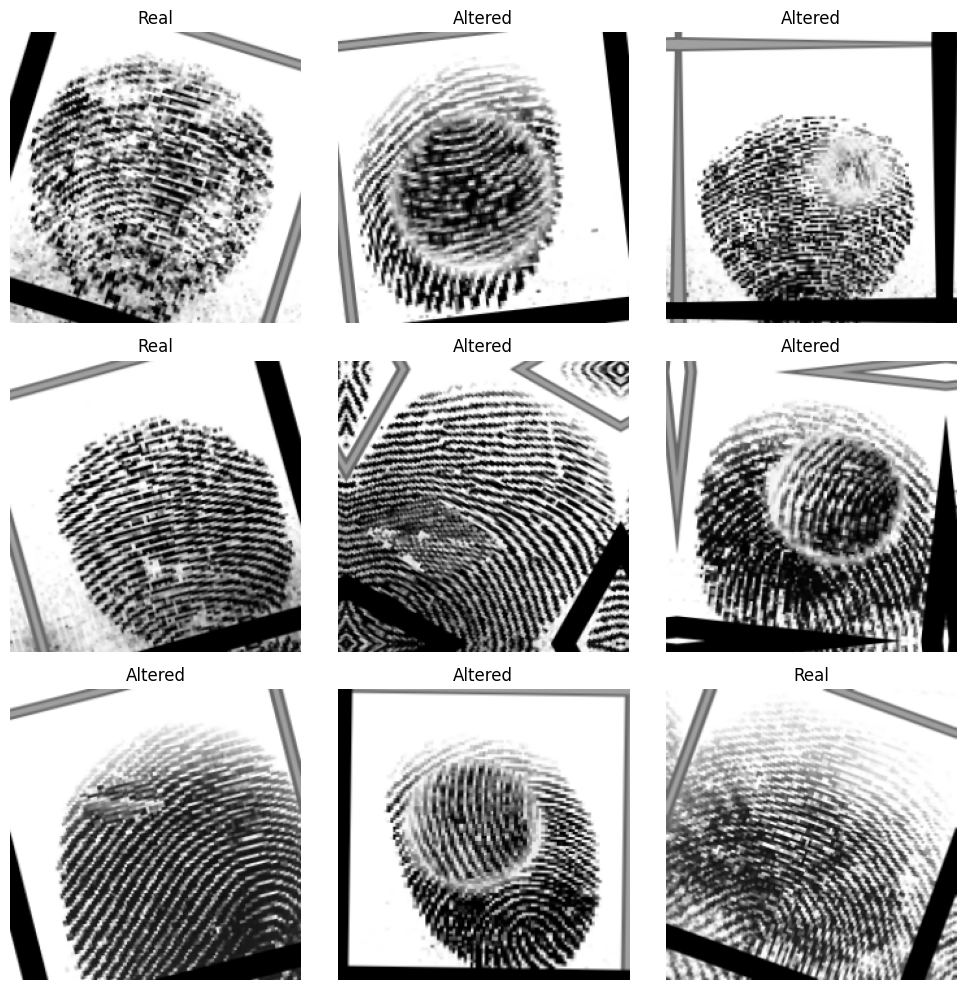

In [ ]:
# Define Data Augmentation Layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
]

# Function to apply data augmentation layers
def apply_data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data augmentation to the training dataset
train_ds = train_ds.map(
    lambda img, label: (apply_data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Data augmentation applied and datasets prefetched.")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")
plt.tight_layout()
plt.show()

## Transfer Learning Model

In [ ]:
from keras.applications import ResNet50
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compiling and training the model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.5656 - loss: 0.8168 - val_acc: 0.5750 - val_loss: 0.6409
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.5061 - loss: 0.8020 - val_acc: 0.6750 - val_loss: 0.6035
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.5445 - loss: 0.7239 - val_acc: 0.7000 - val_loss: 0.5671
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - acc: 0.6588 - loss: 0.6332 - val_acc: 0.7500 - val_loss: 0.5445
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.6584 - loss: 0.5757 - val_acc: 0.8250 - val_loss: 0.5271
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - acc: 0.5896 - loss: 0.5894 - val_acc: 0.8250 - val_loss: 0.5279
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.7128 - loss: 0.5440 - val_acc: 0.8250 - val_loss: 0.5104
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.6094 - loss: 0.6436 - val_acc: 0.8500 - val_loss: 0.5027
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.6129 - loss: 

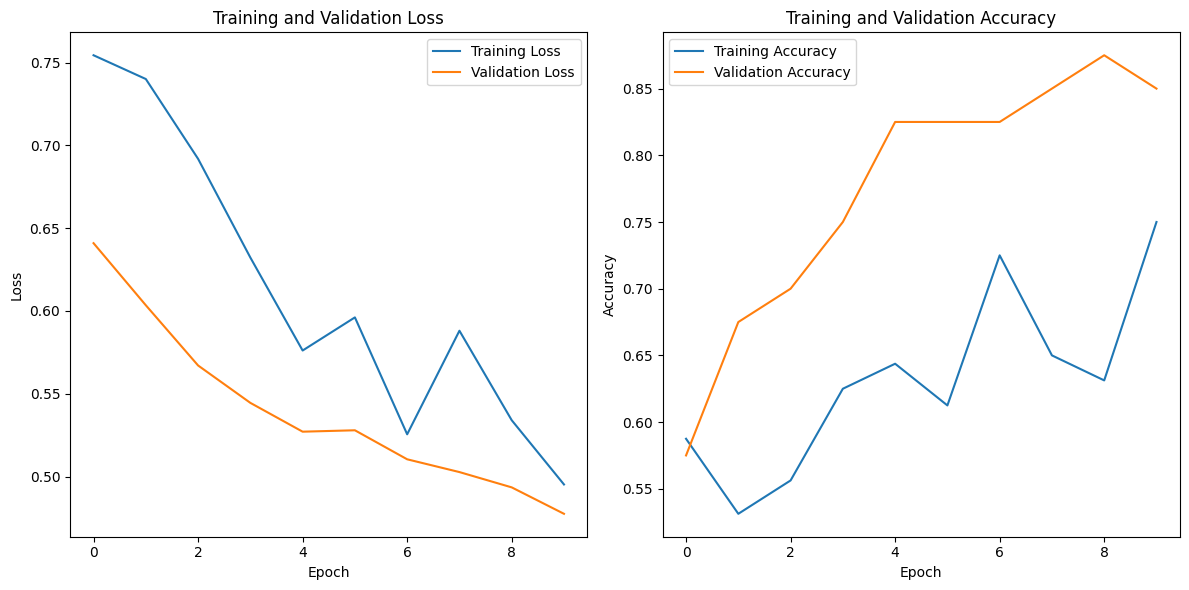

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('augmented_resnet50.keras')

In [ ]:
# Evaluate the ResNet50 base model on the validation dataset
augmented_resnet50_model = keras.models.load_model('augmented_resnet50.keras')
resnet50_aug_eval_results = augmented_resnet50_model.evaluate(val_ds)

print(f"ResNet50 (Augmented) Validation Loss: {resnet50_aug_eval_results[0]:.4f}")
print(f"ResNet50 (Augmented) Validation Accuracy: {resnet50_aug_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.8567 - loss: 0.5496
ResNet50 (Augmented) Validation Loss: 0.4775
ResNet50 (Augmented) Validation Accuracy: 0.8500


### Analysis:


* The accuracy for the training and validation sets both steadily increased then slightly decreased at epoch 10. The training accuracy for the model peaked at about 71% then decreased back down to 70%. The validation accuracy peaked at about 88% then went back down to 85%. The loss for both sets steadily decreased after each epoch.